<a href="https://colab.research.google.com/github/yakaboskic/ENGS_108_Fall_2020/blob/master/assign_6_ENGS_108_Fall_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ENGS 108 Fall 2021 Assignment 6**

*Due October 23 2021

**Instructors:** George Cybenko

**TAs:** Clement Nyanhongo, Jack Sadoff


---

## **Rules and Requirements**


1.   You are only allowed to use Python packages that are explicity imported in 
the assignment notebook or are standard (bultin) python libraries like random, os, sys, etc, (Standard Bultin Python libraries will have a Python.org documentation). For this assignment you may use:
  *   [numpy](https://numpy.org/doc/stable/)
  *   [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html)
  *   [scikit-learn](https://scikit-learn.org/stable/)
  *   [matplotlib](https://matplotlib.org/)
  *   [tensorflow](https://www.tensorflow.org/)

2.   All code must be fit into the designated code or text blocks in the assignment notebook. They are indentified by a **TODO** qualifier.

3. For analytical questions that don't require code, type your answer cleanly in Markdown. For help, see the [Google Colab Markdown Guide](https://colab.research.google.com/notebooks/markdown_guide.ipynb).

---

In [1]:
''' Import Statements '''
from collections import defaultdict
import copy
import itertools

import random
# Don't mess with this (gives reproducible results)
random.seed(444)

## **Problem 1: Reinforcement Learning**
In this problem we will play a game of cops and robbers. The game is played on a fixed undirected, simple, and finite graph $G$. There are two players, a cop and a robber. It is the goal of the cop to catch the robber in as few moves as possible. 

The graph $G$ has the following properties:
  - A total of $m$ nodes.
  - It contains a single $n$ node cycle, where $n\leq m$, and random additional edges to make the graph connected.

The game starts, with the cop taking their choice of vertex in $G$ and then the robber selects a random vertex in $G$ that is not occupied by the cop. At every point in the game both players know the positions of each other, and in this version of the problem we will say that the robber is drunk (i.e. they will randomly choose there next that instead of employing a policy).

The availabe actions of the cop and associated reward function is:
  - Move to a node not connected to their present node (and the cop stays in the current position): -5.
  - Move to an adjacent node (including staying at current node): -1.
  - Move to the node occupied by robber: +100.
>
> **Part 1** Building a Graph Class.
>> **(a)** Using the provided skeleton build a general graph class for this problem for $n$ nodes. You are expected to implement *add_edge*, *make_random_graph*, *check_connected*.

In [176]:
import collections
import copy
import random
import collections
import networkx as nx 
import matplotlib.pyplot as plt

class Graph:
  """ Our graph class.
  Args:
    n: Number of nodes in our cycle.
    m: Total number of nodes in graph, where n >= m.
  """
  def __init__(self, n, m):
        
    if (n > m):
        raise Exception("n <= m must be true")
    self.n = n
    self.m = m
    
    # A default dict is just a dict that won't raise a KeyError, it instead fills
    # the unknown key with a default, in our case an empty list.
    self.G = collections.defaultdict(list)

  def add_edge(self, u, v):
    """
    Make a function that will add an edge to the graph.
    """
    if (u>self.m-1 or v>self.m-1):
        raise Exception("node ids for new edge must both be less than " + str(self.m))

    self.G[u].append(v)


  def make_random_graph(self):
    """ First make a cycle of given length and then add random additional edges
    in such a way that the final graph will be connected.
    """
    #TODO: Make n length cycle first
    count=0
    #make a chain of the first n 
    prevIndex = random.choice(range(self.m))
    #print("prevIndex: " + str(prevIndex))
    remaining_choices = range(self.m)
    #print("remaining choices: "+str(remaining_choices))
    remaining_choices.remove(prevIndex)
    #print("remaining choices: "+str(remaining_choices))

    originalIndex=prevIndex
    for i in range(self.n-1):
        nextIndex = random.choice(remaining_choices)
        self.G[prevIndex].append(nextIndex)
        prevIndex = nextIndex
        remaining_choices.remove(prevIndex)
        #print("remaining choices: "+str(remaining_choices))

    #connect head and tail of chain
    self.G[nextIndex].append(originalIndex)
    
    
    #TODO: Add additional nodes until random graph is connected
    while True:
      _graph = copy.copy(self)
      uNew = random.randint(0,self.m-1)
      vNew = random.randint(0,self.m-1)
      _graph.G[uNew].append(vNew) if vNew not in _graph.G[uNew] else _graph.G[uNew]

      if self.check_connected(_graph):
        # If it is set the current graph's adjacency matrix equal to the copy's.
        self.graph = _graph.G
        # Return (i.e. break the loop)
        return True

  def check_connected(self, G):
    """ Perform a Depth First Search.
    """
    start_node = random.choice(list(G.G.keys()))
    return dfs(G, [], start_node)

#note that "parent" param is not strictly necessary
#as long as we check whether a child node is already
#in the listed of visited nodes before calling the 
#recursive function on it

def dfs(G, visited, u):
    """ Implement your own depth first search. Many online resources for this.
    Args:
    G: Is the graph (adjency matrix) we want to test.
    visited: Is a dictionary that keeps track of the nodes you've visited.
    u: a starting node.
    Returns:
    True: If all nodes have been visited at least once.
    False: Otherwise.
    """
    adjacent_nodes = G.G[u]
    for node in adjacent_nodes:
        if node not in visited:
            visited.append(node)
            dfs(G,visited,node)
    if len(visited)==G.m:
        return(True)
    else: return(False)



>> **(b)** Test out your graph class with a cops and robbers graph of $n=5$ and $m=10$.

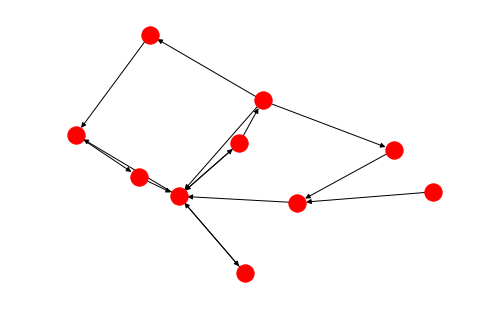

In [177]:
g = Graph(5,10)
g.make_random_graph()

plotGraph = nx.DiGraph() 

for i in range(g.m): 
 for j in range( g.m): 
   if j in g.G[i]: 
      plotGraph.add_edge(i,j) 
nx.draw( plotGraph) 
plt.show() 

> **Part 2** Understanding the state space, i.e. the Game.
>> **(a)** Given the graph class you've created in Part 1. Develop a Cops and Robbers game class. Use the skeleton below to implement the following functions first: *get_successors*, *terminal_test*, *result*. 


In [178]:
class CopsAndRobbers:
  def __init__(self, graph, start_state, rewards_table=None):
    """ This is the cops and robbers game class.
    Args:
      start_state: The starting state of the cop position and robber position in
        the graph. Should be a tuple of form (cop_pos, rob_pos).
      G: The graph adjacency matrix
      state: current state in the game.
      reward_table: The (state, actions) reward dictionary that you will eventually implement.
    """
    self.graph = graph
    self.G = graph.G
    self.state = start_state
    self.rewards_table = rewards_table

  def terminal_test(self, state):
    """test for terminal condition"""
    if (state[0]==state[1]): 
        #print("state[0]: " + str(state[0]) + ", state[1]: " + str(state[1]))
        return(True)
    else: return(False)
    
  def get_successors(self, state):
    """ Return a list of successor states that can be reached from the current state.
    Hint: Remember only the cop can choose their action.
    """
    copNextStates = self.G[state[0]]
    #cop should be able to stay still
    copNextStates.append(state[0]) if state[0] not in copNextStates else copNextStates
    
    successorStates = []
    for i in copNextStates:
        successorStates.append((i,state[1]))
    return(successorStates)

  def get_successors_robber(self, state):
    """ Return a list of successor states that can be reached from the current state after the robber moves.
    """
    robNextStates = self.G[state[1]]
    #robber should be able to stay still
    robNextStates.append(state[1]) if state[1] not in robNextStates else robNextStates
    
    successorStates = []
    for i in robNextStates:
        successorStates.append((state[0],i))
    return(successorStates)

  def result(self, next_state):
    """ This function should return the state after the cop has made their move,
    and the drunk robber has moved accordingly.
    Args:
      state: Current state of (cop, rob).
      next_state: The state after the cop has moved (next_cop, rob). Calculated from get_successors.
    """
    
    successorStates = self.get_successors_robber(next_state)
    #print("robber successor states: " + str(successorStates))
    final_state = random.choice(successorStates)
    #print("robber moved from " + str(next_state) + " to " + str(final_state))
    return(final_state)

  #I'm not going to use this function. Because in order for it to be useful, this should 
  # be based on the calculate_rewaard_table method, which is not defined yet. So unless I
  #re-arranged the questions, I would have to re-define this class again using that function!
  def utility(self, state, action):
    return self.rewards_table[(state, action)]

CR = CopsAndRobbers(g,(0,1))
CR.get_successors(CR.state)
CR.terminal_test((1,1))

True

>> **(b)** In reinforcement learning we are often interested in calculating a rewards table that has possible states as its rows and possible actions as its columns and filled in with the associated reward given the Q(state, action) pair. Calculate the rewards table for any given graph. *Hint: This should be an $m^2$ x $m$ matrix or a dictionary with $m^3$ keys such that the keys are (state, action) tuples.*  

In [179]:
def calculateRewardsTable(graph):
  """ Make a rewards table dictionary of the from table[(state, action)] = reward. recall:
  The availabe actions of the cop and associated reward function is:

  Move to a node not connected to their present node (and the cop stays in the current position): -5.
  Move to an adjacent node (including staying at current node): -1.
  Move to the node occupied by robber: +100.
  """
  table = collections.defaultdict(list)
  for c_state_ind in range(graph.m):
    for r_state_ind in range(graph.m):
        for action in range(graph.m):
            reward = 0
            cop_robber = (c_state_ind,r_state_ind)
            if action in graph.G[c_state_ind]:
                if (action==r_state_ind):
                    reward=100
                else: reward=-1
            else:
                if (c_state_ind==r_state_ind):
                    reward=100
                else: reward = -5
            table[(cop_robber,action)]=reward
  return table



>> **(c)** Now that we have our reward table, try to solve the problem in a brute-force manner (without reinforcement learning). I.e. try to reach the terminal state, or find get a reward of 100. 

In [181]:

cr = CopsAndRobbers(g,(1,8))
def simulate_random(cr_temp,verbose=False):
# Simulation loop
    epochs=0
    rewards = []
    penalties = 0
    rTable = calculateRewardsTable(cr_temp.graph)

    while True:
        epochs=epochs+1
        
        previousState = cr_temp.state
        if verbose:
            print("epoch #" + str(epochs))
            print("previousState: " + str(previousState))
        attemptedNextCopState = random.choice(range(cr_temp.graph.m))
        
        nextStateWithoutRobberMoving = (attemptedNextCopState,previousState[1])
        #optimistically set next cop state
        #if cop moved to non-adjacent node, reset their position
        attemptedNextState = cr_temp.result(nextStateWithoutRobberMoving)
        #we need attemptedNextStateWithoutCopMoving in order to calculate the appropriate reward 
        #after the cop's action calculate reward based on previous state of cops and robbers and new state of cop
        attemptedNextStateWithoutCopMoving = (previousState[0],attemptedNextState[1])
        
        # in order to calculate reward based on both the cop's action and the 
        # robber's simultaneous random reaction, we take reward((old_cop_state,new_robber_state),new_cop_state)
        reward = rTable[attemptedNextStateWithoutCopMoving,attemptedNextState[0]]
        if verbose:
            print("reward: " + str(reward))
            print("attemptedNextState: " + str(attemptedNextState))
        rewards.append(reward)

        # note that we could just as well skip the getSuccessors functionality entirely,
        # and just check whether the reward is 0 before re-setting. but I opted to use that function.
        
        # get successor states where robber is the same as current (robber hasn't moved yet)
        cSuccessors = cr_temp.get_successors(previousState)
        if verbose:
            print("cop successors: " + str(cSuccessors))
        nextState = attemptedNextState
        if (attemptedNextCopState,previousState[1]) not in cSuccessors:
            allowedCopTransition = True
            nextState = (previousState[0],nextState[1])
            if verbose:
                print("attempted to move cop from " + str(previousState[0]) + " to non-adjacent node " + str(attemptedNextCopState))
        else:
            if verbose:
                print("moved cop from " + str(previousState[0]) + " to adjacent node " + str(attemptedNextCopState))

            
        if verbose:
            print("next state: " + str(nextState))
        cr_temp.state = nextState
        
        if (cr_temp.terminal_test(nextState)):
            break
    return(rewards,epochs)

rewards,term = simulate_random(cr,verbose=True)
print("rewards: " + str(sum(rewards)) + ", # epochs to terminate: " + str(term))

defaultdict(<type 'list'>, {0: [2, 6, 0, 7], 1: [6, 1], 2: [1], 3: [9], 4: [0, 6], 5: [6], 6: [4, 5, 3], 7: [3], 8: [8, 1], 9: [6]})
epoch #1
previousState: (1, 8)
reward: -5
attemptedNextState: (9, 8)
cop successors: [(6, 8), (1, 8)]
attempted to move cop from 1 to non-adjacent node 9
next state: (1, 8)
epoch #2
previousState: (1, 8)
reward: -5
attemptedNextState: (0, 8)
cop successors: [(6, 8), (1, 8)]
attempted to move cop from 1 to non-adjacent node 0
next state: (1, 8)
epoch #3
previousState: (1, 8)
reward: -5
attemptedNextState: (0, 8)
cop successors: [(6, 8), (1, 8)]
attempted to move cop from 1 to non-adjacent node 0
next state: (1, 8)
epoch #4
previousState: (1, 8)
reward: -5
attemptedNextState: (3, 8)
cop successors: [(6, 8), (1, 8)]
attempted to move cop from 1 to non-adjacent node 3
next state: (1, 8)
epoch #5
previousState: (1, 8)
reward: 100
attemptedNextState: (7, 1)
cop successors: [(6, 8), (1, 8)]
attempted to move cop from 1 to non-adjacent node 7
next state: (1, 1)
r

> **Part 3** Q-learning. 
>
> Up to this point we have build a graph class, built a game class, ran a brute-force simulation of an agent traversing the space randomly, and now we will dive into Q-learning in the hopes of maximizing the rewards and efficiency of capturing the drunk robber. 
>
>> **(a)** Using the skeleton from the brute force method, implement a training loop to learn a Q-table for a given graph and game. 

In [182]:
class QTable:
    def __init__(self,graph,alpha=.1,gamma=.1):
        self.n_states = graph.m
        self.RTable = calculateRewardsTable(graph)
        #initialize q table
        table = collections.defaultdict(list)
        for c_state_ind in range(graph.m):
            for r_state_ind in range(graph.m):
                for action in range(graph.m):
                    cop_robber = (c_state_ind,r_state_ind)
                    table[(cop_robber,action)]=0
        self.QTable = table
        self.alpha = alpha
        self.gamma = gamma
        
    def setQTable(self,state,action,value):
        #print("setting qtable value for state " + str(state) + " and action " + str(action) + " to " + str(value))
        self.QTable[state,action]=value

      
    


>> **(b)** Evalute your new Q-learning agent over a 100 epochs, by choosing your actions based on the argmax of the Q-table caluculated in (a) and report the average number of penalities, average time, and average number of steps it took to find the robber with your new Q-learning strategy. 

In [174]:
g2 = Graph(5,10)
g2.make_random_graph()
print(str(g2.G))

prevIndex: 7
remaining choices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
remaining choices: [0, 1, 2, 3, 4, 5, 6, 8, 9]
remaining choices: [0, 2, 3, 4, 5, 6, 8, 9]
remaining choices: [2, 3, 4, 5, 6, 8, 9]
remaining choices: [3, 4, 5, 6, 8, 9]
remaining choices: [3, 4, 5, 6, 8]
defaultdict(<type 'list'>, {0: [2, 0], 1: [0, 7, 3], 2: [9, 7, 4, 8, 6], 3: [2, 5], 4: [3, 8, 2], 5: [], 6: [9], 7: [1, 2, 4], 8: [7], 9: [7, 8, 0, 1]})


In [184]:
cr2 = CopsAndRobbers(g2,(0,1))
def QLearningSim(cr_temp,verbose=False):
    epochs = 0
    rewards = []
    penalties = 0
    rTable = calculateRewardsTable(cr_temp.graph)
    qTable= QTable(cr_temp.graph,alpha=.5,gamma=.5)
    # Simulation loop
    while True:
        epochs=epochs+1
        if verbose:
            print("epoch #" + str(epochs))
        previousState = cr_temp.state

        if verbose:
            print("previous state: " + str(previousState))
        bestQVal = -10000
        bestAction = None
        for i in range(cr_temp.graph.m):
            qVal = qTable.QTable[previousState,i]
            if qVal>bestQVal:
                bestQVal = qVal
                bestAction = i
        if verbose:
            print("best action: " + str(bestAction))

        nextStateWithoutRobberMoving = (bestAction,previousState[1])
        attemptedNextState = cr_temp.result(nextStateWithoutRobberMoving)
        attemptedNextStateWithoutCopMoving = (previousState[0],attemptedNextState[1])
        reward = rTable[attemptedNextStateWithoutCopMoving,attemptedNextState[0]]    
        if verbose:
            print("reward: " + str(reward))
        rewards.append(reward)

        cSuccessors = cr_temp.get_successors(previousState)
        nextState = attemptedNextState
        if verbose:
            print("cop successors: " + str(cSuccessors))
            print("next state: " + str(nextState))
        if (bestAction,previousState[1]) not in cSuccessors:
            if verbose:
                print("attempted to move cop from " + str(previousState[0]) + " to non-adjacent node " + str(bestAction))
            nextState = (previousState[0],nextState[1])
        else: 
            if verbose: 
                print("moved cop from " + str(previousState[0]) + " to adjacent node " + str(bestAction))


        oldQVal = qTable.QTable[previousState,bestAction]

        bestAction = None
        highestQ = -1000000

        for thisAction in range(cr_temp.graph.m):
            thisQ = qTable.QTable[nextState,thisAction]
            if thisQ>highestQ:
                highestQ = thisQ
                bestAction = thisAction

        #print("self.alpha: "+str(qTable.alpha)+ ", oldQVal: " + str(oldQVal) + ", reward: " + str(reward) + ", self.gamma: " + str(qTable.gamma) + ", highestQ: " + str(highestQ))
        newQVal = (1-qTable.alpha)*oldQVal+qTable.alpha*(reward+qTable.gamma*highestQ)
        if verbose:
            print("setting new q value for state "+str(previousState)+" and action " + str(bestAction) +": " + str(newQVal))    
        qTable.setQTable(previousState,bestAction,newQVal)
        if (cr_temp.terminal_test(nextState)):
            break
    return(rewards,epochs)
rewards, term = QLearningSim(cr2,verbose=True)
print("rewards: " + str(rewards) + ", epochs to terminate: " + str(term))

epoch #1
previous state: (0, 1)
best action: 0
reward: -1
cop successors: [(2, 1), (0, 1)]
next state: (0, 7)
moved cop from 0 to adjacent node 0
setting new q value for state (0, 1) and action 0: -0.5
epoch #2
previous state: (0, 1)
best action: 1
reward: -5
cop successors: [(2, 1), (0, 1)]
next state: (1, 3)
attempted to move cop from 0 to non-adjacent node 1
setting new q value for state (0, 1) and action 0: -2.5
epoch #3
previous state: (0, 1)
best action: 1
reward: 100
cop successors: [(2, 1), (0, 1)]
next state: (1, 0)
attempted to move cop from 0 to non-adjacent node 1
setting new q value for state (0, 1) and action 0: 50.0
rewards: [-1, -5, 100], epochs to terminate: 3


>> **(c)** Compare your results with the brute-force method used in Part 2 and comment on the improvement. For instance, try varying graph configurations and look for any signs of improvement in certian instances. 

Note that the performance depends not only on the shape and size of the graph, but also very crucially on the initial positions of the cop and the robber. In order to really test which one is performing better, we should iterate over several random initial positions, running both algorithms on each, and then summarize the results. 

In [221]:
import numpy as np
def run_tests(n=4,n_sim=100):

    test_graph = Graph(n,8)
    test_graph.make_random_graph()
    #print(str(test_graph.G))
    
    total_rewards_rand = []
    terms_rand = []
    total_rewards_q = []
    terms_q = []

    for i in range(n_sim):
        initialCop = random.choice(range(test_graph.m))
        newList = range(test_graph.m)
        #print("newList: " + str(newList))
        newList.remove(initialCop)
        #print("newList2: " + str(newList))

        initialRobber = random.choice(newList)
        
        #print("initial cop: " + str(initialCop) + ", initialRobber: " + str(initialRobber))
        #cr3 = CopsAndRobbers(test_graph,(initialCop,initialRobber),rTable2)
        cr3 = CopsAndRobbers(test_graph,(initialCop,initialRobber))

        random_sim_rewards,random_sim_term = simulate_random(cr3,verbose=False)
        total_rewards_rand.append(sum(random_sim_rewards))
        terms_rand.append(random_sim_term)
        #print("random sim total reward: " + str(sum(random_sim_rewards)) + ", random sim epochs: " + str(random_sim_term))
        q_sim_rewards,q_sim_term = QLearningSim(cr3,verbose = False)
        total_rewards_q.append(sum(q_sim_rewards))
        terms_q.append(q_sim_term)
        #print("q sim total reward: " + str(sum(q_sim_rewards)) + ", q sim epochs: " + str(q_sim_term))

    
    print("mean total rewards for random sim over "+str(n_sim) +" simulations: " + str(np.mean(total_rewards_rand)))
    print("mean total rewards for q sim over "+str(n_sim) +" simulations: " + str(np.mean(total_rewards_q)))
    print("mean term for random sim over "+str(n_sim) +" simulations: "  + str(np.mean(terms_rand)))
    print("mean term for q sim over "+str(n_sim) +" simulations: "  + str(np.mean(terms_q)))


run_tests()

mean total rewards for random sim over 100 simulations: 74.62
mean total rewards for q sim over 100 simulations: 93.08
mean term for random sim over 100 simulations: 8.9
mean term for q sim over 100 simulations: 3.0


it appears that the q-learning version is much better than brute force search. At first when I saw these results, I thought maybe that there was a bias towards the Q-Learning algorithm that was not very generalizable, because of the way my cycles were being generated. Because of the way the Q-learning algorithm takes the argmax of the Q values as its action, which are initially all 0, this means that it will try each action in order, at least at the beginning of the algorithm. So if the cycle is also structured in a way that correlates with the node indices because of the way it is constructed, this could create a bias for the q-learning algorithm that is not real (because we should be able to permute the indices without changing the general results). 
But then I made sure to choose random indices when creating that cycle initially, and the same overall result remained, which was that the q-learning algorithm did much better. It had much higher rewards, and converged much quicker. 
To check for how it depends on different raph configurations, I looked at a graph where the total number of nodes was the same, but the cycle size was very large, or very small. Below are the results for (m=8,n=6), and (m=8,n=2).

In [219]:
run_tests(2,n_sim=100)

mean total rewards for random sim over 100 simulations: 41.88
mean total rewards for q sim over 100 simulations: 97.71
mean term for random sim over 100 simulations: 17.8
mean term for q sim over 100 simulations: 2.29


The improvement of q-learning over brute force method was more exaggerated for the case where the cycle was smaller relative to the graph. And the two strategies were closer when the cycle was larger relative to the graph. My interpretation of this is that if there is only a small cycle, then the cop should be able to have some concrete idea of how "far" they are from the robber, and therefore in many situations should be able to pick an action that moves the cop "closer" to the robber. Whereas if the graph is more cyclic, then there may be no way to make a move that guarantees the cop always gets closer to the robber.

> **Bonus** Check that the learned policy satsifies the [Bellman Inequality](https://towardsdatascience.com/mathematical-analysis-of-reinforcement-learning-bellman-equation-ac9f0954e19f), i.e is the computed solution the actual optimal policy?

#TODO: Your code goes here.
well, the solution depends on two parameters that I chose arbitrarily, gamma and alpha. So it is highly unlikely that this is truly the optimal policy. However, given a specific gamma and alpha, the policy satisfies the bellman inequality because the process is a markov decision process, which means that the optimal policy at a given state must have an expected utility equal to the expected utility from the current policy applied to the current state, plus the maximum expected utility at the next state. Since the policy is chosen as the highest value of Q for the given state, and the q table gets updated based on the best possible action from the subsequent state, this condition is satisfied according to our policy.